# Norman analysis

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [139]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import rapids_singlecell as rsc
import numpy as np
import scanpy as sc
import pandas as pd
import scipy
import numpy as np
import tqdm
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.X = adata.layers["counts"].copy()
    del adata.layers
    gc.collect()
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'

In [209]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "norman_v1"
)
vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_v1/model.pt already downloaded  


In [210]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2010768/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [211]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [213]:
sublatent = DM.configurations.get_by_obs_key("condition").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(latent, n_neighbors=50)
rsc.tl.umap(latent)
rsc.utils.anndata_to_CPU(latent)

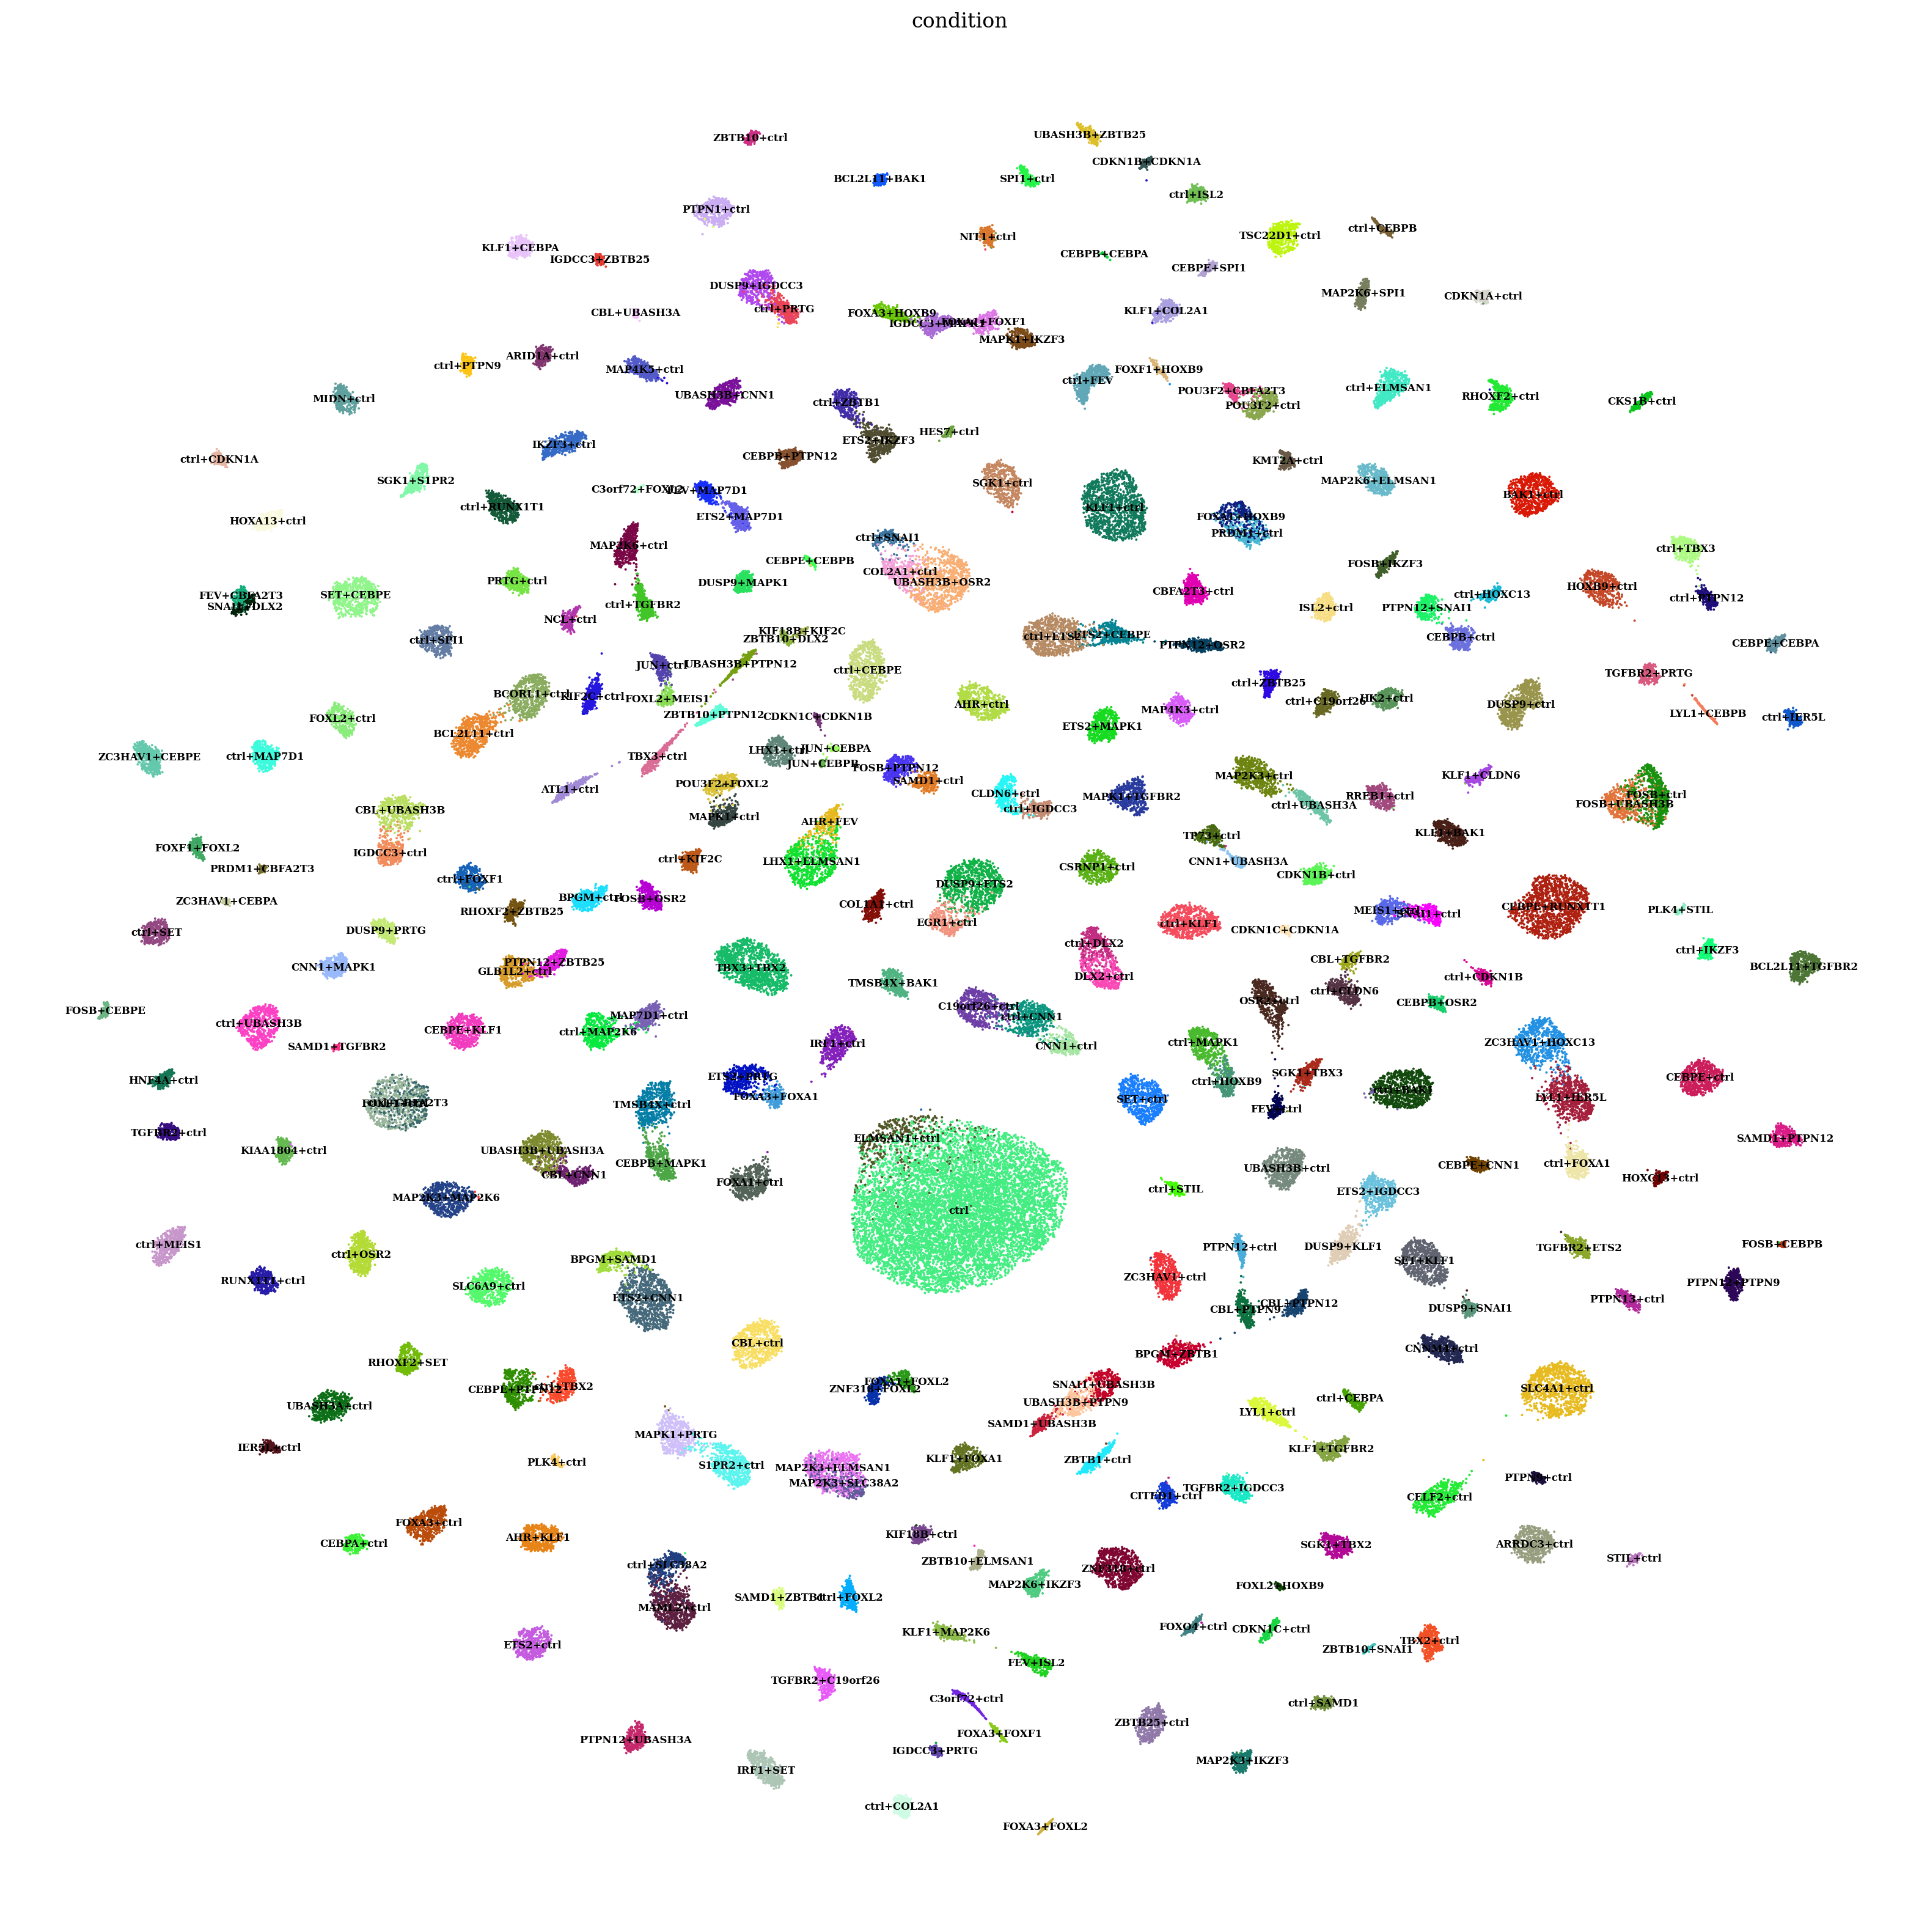

In [215]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = latent.obs["condition"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(20, 20))
    sc.pl.umap(
        latent, 
        color=["condition"], 
        ncols=1,
        size=8,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

In [216]:
def calculate_centroids_iqr(data, labels, multiplier=1.5):
    """
    Calculate centroids excluding outliers based on IQR.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
        multiplier (float): Multiplier for the IQR to define the confidence interval.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition.
    """
    unique_conditions = np.unique(labels)
    mean_centroids = dict()

    for condition in tqdm.tqdm(unique_conditions):
        condition_data = data[labels == condition]
        Q1 = np.percentile(condition_data, 25, axis=0)
        Q3 = np.percentile(condition_data, 75, axis=0)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # Filtering out the outliers
        is_not_outlier = np.all((condition_data >= lower_bound) & (condition_data <= upper_bound), axis=1)
        filtered_data = condition_data[is_not_outlier]

        # Calculate the mean of the filtered data
        mean_centroids[condition] = np.mean(filtered_data, axis=0)

    return mean_centroids


In [217]:
def calculate_centroids_median(data, labels):
    """
    Calculate centroids using the median to be robust against outliers.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition based on the median.
    """
    unique_conditions = np.unique(labels)
    median_centroids = dict()

    for condition in tqdm.tqdm(unique_conditions):
        condition_data = data[labels == condition]
        # Computing the median across rows for this condition
        median_centroids[condition] = np.median(condition_data, axis=0)

    return median_centroids


In [218]:
labels = latent.obs["condition"].to_numpy().flatten()
centroids_iqr = calculate_centroids_iqr(latent.X, labels=labels, multiplier = 1.0)
centroids_median = calculate_centroids_median(latent.X, labels=labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 487.65it/s]


In [219]:
the_same = dict()
singles = set()
doubles = set()
singles_dict = dict()

for c in latent.obs["condition"].unique():
    if "+" not in c:
        assert c == "ctrl"
        k = ("ctrl", "ctrl")
    else:
        assert c.count("+") == 1
        k = tuple(sorted(c.split("+")))
            
    if k not in the_same:
        the_same[k] = []
    the_same[k].append(c)


    if "ctrl" in k:
        singles.add(k)
        i = list(k).index("ctrl")
        l = k[0] if i==1 else k[1]
        if l not in singles_dict:
            singles_dict[l] = []
        singles_dict[l].append(k)
    else:
        doubles.add(k)

In [220]:
combinations = []
for d1, d2 in doubles:
    css = the_same[(d1, d2)]
    d1s = singles_dict[d1]
    d2s = singles_dict[d2]
    d1ss = {j for i in d1s for j in the_same[i]}
    d2ss = {j for i in d2s for j in the_same[i]}
    assert len(css) == 1
    css = css[0]
    combinations.append([css, list(d1ss), list(d2ss)])    

In [290]:
centroids = centroids_median

vectors = dict()
for combin, perturb1, perturb2 in combinations:
    for perturb in [perturb1, perturb2]:
        for pertur in perturb:
            pertur_vector = centroids[pertur] - centroids["ctrl"]
            vectors[pertur] = pertur_vector
    combin_vector = centroids[combin] - centroids["ctrl"]
    vectors[combin] = combin_vector
for s in singles:
    for ss in the_same[s]:
        if ss not in vectors:
            vectors[ss] = centroids[ss] - centroids["ctrl"]

In [291]:
combination_distance = []
for combin, perturb1, perturb2 in combinations:
    true_vector = vectors[combin]
    prediction_vector = vectors[perturb1[0]] + vectors[perturb2[0]]
    combination_distance.append(scipy.spatial.distance.euclidean(true_vector, prediction_vector))

In [292]:
sames = set()
for i in the_same:
    if len(the_same[i]) > 1:
        for j in the_same[i]:
            sames.add(j)

In [293]:
singles_set = set()
for s in singles:
    for ss in the_same[s]:
        singles_set.add(ss)
singles_set = list(singles_set)

In [294]:
combination_distance_singles = []
for ind, ss1 in enumerate(singles_set):
    for ss2 in singles_set[ind:]:
        if ss1 != ss2:
            combination_distance_singles.append(scipy.spatial.distance.euclidean(vectors[ss1], vectors[ss2]))

In [295]:
combination_distance_singles_same = []
for k, v in the_same.items():
    if len(v) > 1:
        assert len(v) == 2
        ss1, ss2 = v
        combination_distance_singles_same.append(scipy.spatial.distance.euclidean(vectors[ss1], vectors[ss2]))

In [296]:
np.median(combination_distance_singles), np.median(combination_distance_singles_same), np.median(combination_distance)

(6.571521997451782, 2.522726058959961, 6.8153862953186035)

In [297]:
combination_distance

[8.84994125366211,
 7.047540664672852,
 5.69146203994751,
 7.521850109100342,
 2.8001866340637207,
 4.712368488311768,
 9.234830856323242,
 8.622303009033203,
 3.6809279918670654,
 4.295713424682617,
 2.965505361557007,
 5.553394317626953,
 11.120189666748047,
 6.358924388885498,
 10.134892463684082,
 7.614660263061523,
 7.373108863830566,
 7.291487693786621,
 9.056868553161621,
 4.993471145629883,
 3.162346124649048,
 3.8850107192993164,
 5.732063293457031,
 8.378570556640625,
 3.2137954235076904,
 6.874996185302734,
 8.873943328857422,
 11.280770301818848,
 9.014720916748047,
 9.538445472717285,
 9.21257495880127,
 8.11607837677002,
 7.456247806549072,
 9.75439739227295,
 6.59038782119751,
 4.587738990783691,
 4.953909873962402,
 4.3149800300598145,
 6.525481224060059,
 1.7411359548568726,
 4.854923725128174,
 4.153954982757568,
 6.1310133934021,
 7.235039710998535,
 9.833374977111816,
 3.786041498184204,
 4.322065353393555,
 1.2053768634796143,
 4.499310493469238,
 5.865283012390137

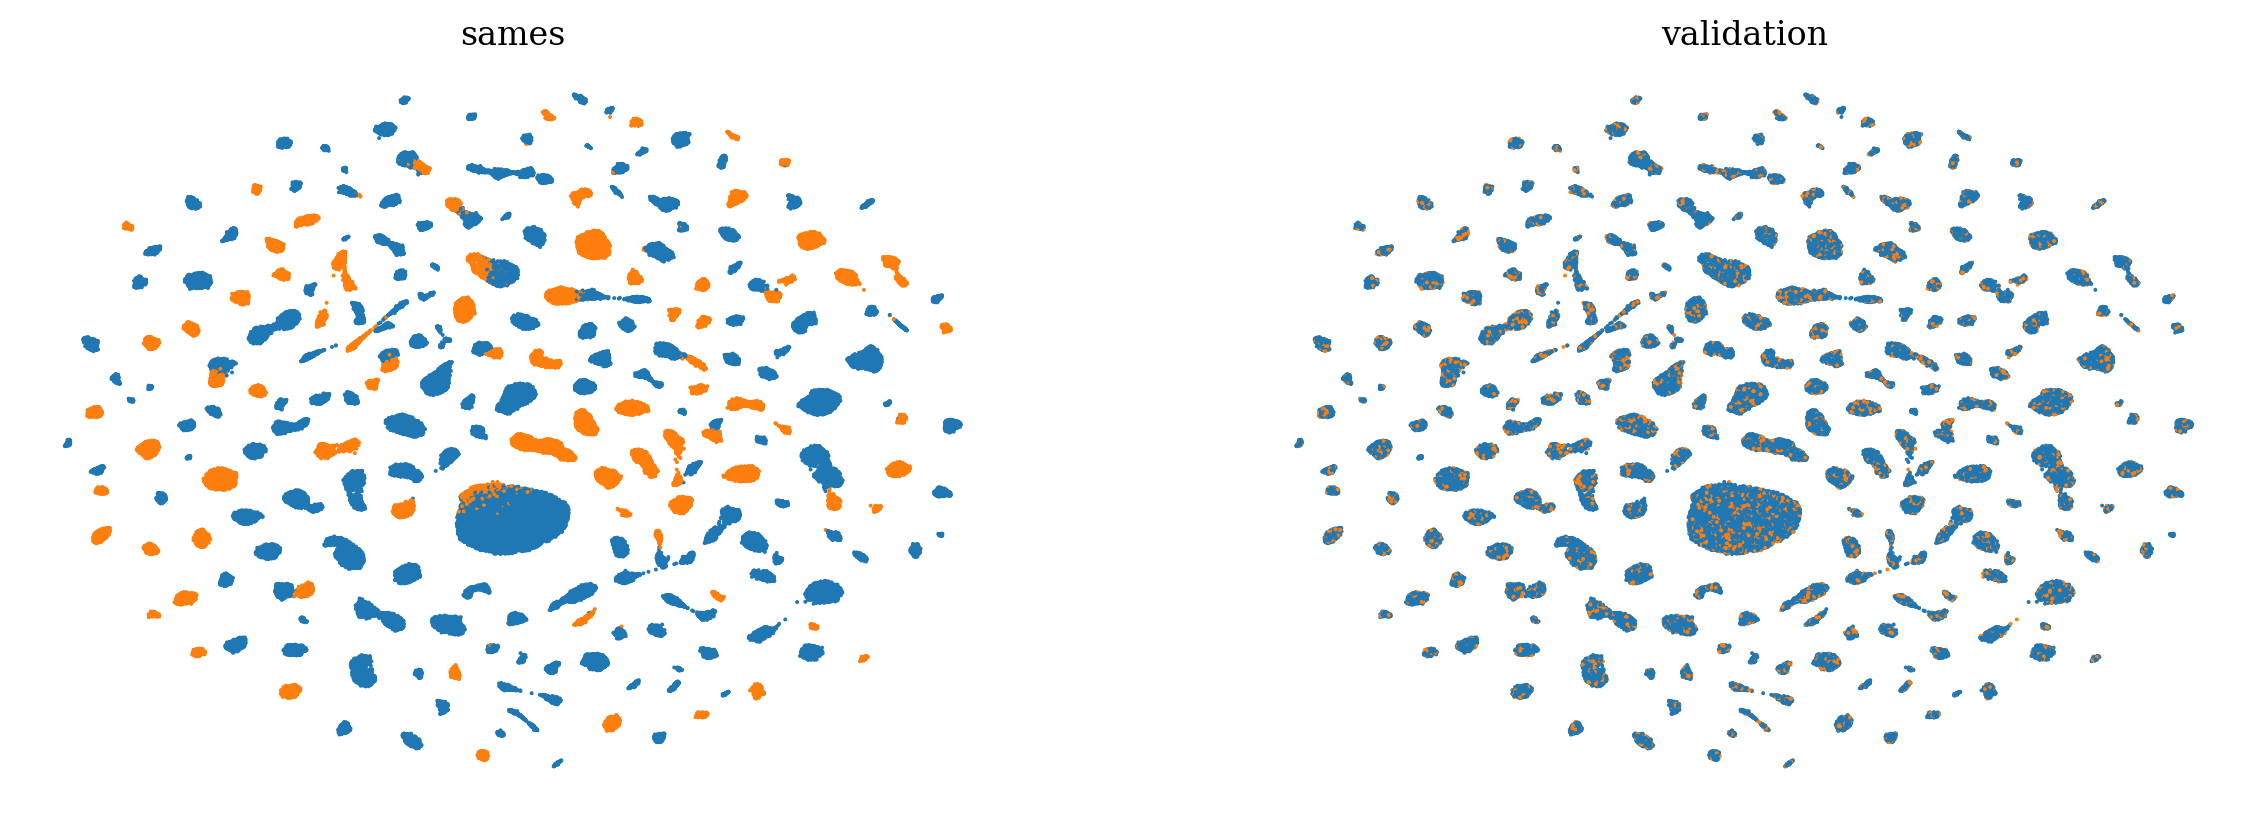

In [298]:
latent.obs["sames"] = latent.obs["condition"].isin(sames).astype(int).astype(str)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["sames", "validation"], 
        ncols=2,
        size=8,
        frameon=False,
        legend_loc=None,
        legend_fontsize=6,
        legend_fontweight='bold'
    )

In [48]:
# resolution = 1.12345
# rsc.tl.leiden(latent, resolution=np.round(resolution, 3), key_added="leiden_" + format(resolution, ".3f"))